=== Data Overview ===
Total Rows: 1000
Time Range: 2023-12-30 15:29:12 to 2024-12-28 11:00:00

Missing Values:
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
ProductName        0
Category           0
ProductPrice       0
CustomerName       0
Region             0
SignupDate         0
dtype: int64

Descriptive Stats:
          Quantity       Price   TotalValue
count  1000.000000  1000.00000  1000.000000
mean      2.537000   272.55407   689.995560
std       1.117981   140.73639   493.144478
min       1.000000    16.08000    16.080000
25%       2.000000   147.95000   295.295000
50%       3.000000   299.93000   588.880000
75%       4.000000   404.40000  1011.660000
max       4.000000   497.76000  1991.040000


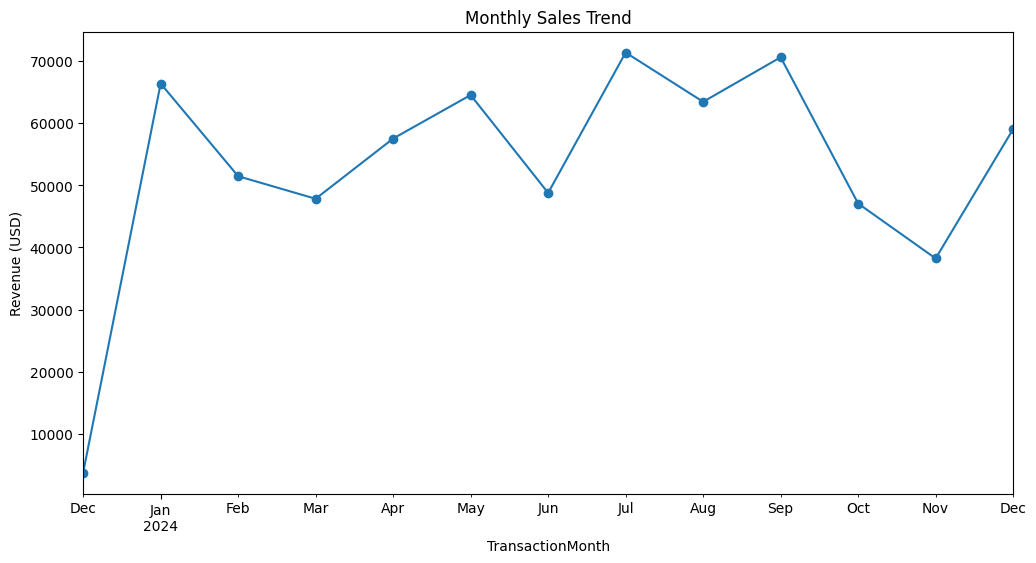

C:\Users\HP\AppData\Local\Temp\ipykernel_205064\2760061239.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=category_revenue.values, y=category_revenue.index, palette='viridis')


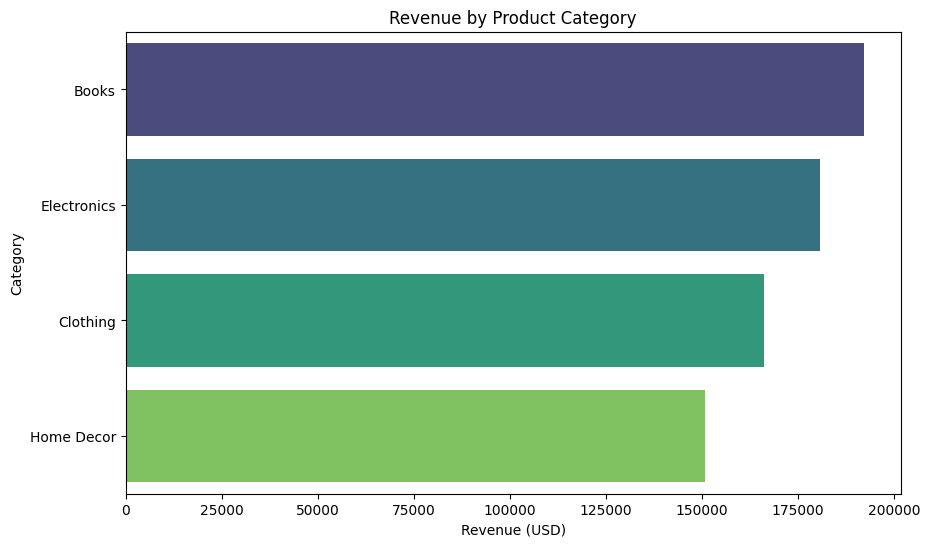

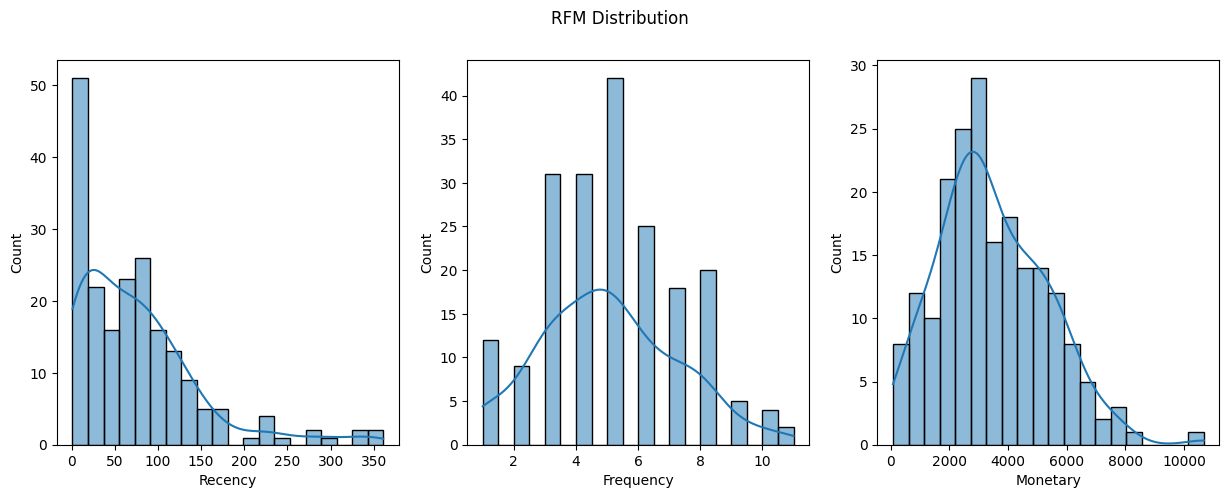

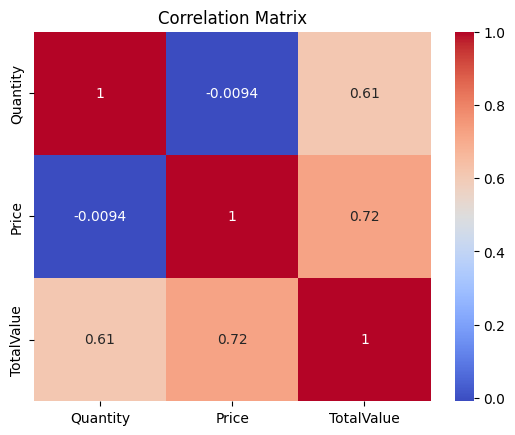


=== Regional Performance ===
                 TotalValue                        CustomerID
              Total Revenue Avg. Order Value Unique Customers
Region                                                       
Asia              152074.97       697.591606               44
Europe            166254.63       710.489872               50
North America     152313.40       624.235246               46
South America     219352.56       721.554474               59


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data with corrected column names
customers = pd.read_csv("Customers.csv", parse_dates=["SignupDate"])
products = pd.read_csv("Products.csv").rename(columns={"Price": "ProductPrice"})  # Rename to avoid conflict
transactions = pd.read_csv("Transactions.csv", parse_dates=["TransactionDate"])

# Merge data with explicit column handling
merged_data = (
    transactions
    .merge(products, on="ProductID")
    .merge(customers, on="CustomerID")
)

# 1. Data Overview (Updated to use correct columns)
print("=== Data Overview ===")
print(f"Total Rows: {len(merged_data)}")
print(f"Time Range: {merged_data['TransactionDate'].min()} to {merged_data['TransactionDate'].max()}")
print("\nMissing Values:")
print(merged_data.isnull().sum())
print("\nDescriptive Stats:")
print(merged_data[['Quantity', 'Price', 'TotalValue']].describe())  # Now 'Price' exists


# 2. Temporal Analysis (Monthly Sales)
merged_data['TransactionMonth'] = merged_data['TransactionDate'].dt.to_period('M')
monthly_sales = merged_data.groupby('TransactionMonth')['TotalValue'].sum()
plt.figure(figsize=(12, 6))
monthly_sales.plot(kind='line', marker='o', title='Monthly Sales Trend')
plt.ylabel('Revenue (USD)')
plt.show()

# 3. Product Category Insights
category_revenue = merged_data.groupby('Category')['TotalValue'].sum().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=category_revenue.values, y=category_revenue.index, palette='viridis')
plt.title('Revenue by Product Category')
plt.xlabel('Revenue (USD)')
plt.show()

# 4. Customer RFM Analysis
snapshot_date = merged_data['TransactionDate'].max() + pd.DateOffset(days=1)
rfm = merged_data.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'TransactionID': 'count',                                     # Frequency
    'TotalValue': 'sum'                                           # Monetary
}).rename(columns={'TransactionDate': 'Recency', 'TransactionID': 'Frequency', 'TotalValue': 'Monetary'})

# RFM Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(rfm['Recency'], bins=20, ax=axes[0], kde=True)
sns.histplot(rfm['Frequency'], bins=20, ax=axes[1], kde=True)
sns.histplot(rfm['Monetary'], bins=20, ax=axes[2], kde=True)
plt.suptitle('RFM Distribution')
plt.show()

# 5. Correlation Analysis
corr_matrix = merged_data[['Quantity', 'Price', 'TotalValue']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# 6. Regional Analysis
region_stats = merged_data.groupby('Region').agg({
    'TotalValue': ['sum', 'mean'],
    'CustomerID': 'nunique'
}).rename(columns={'sum': 'Total Revenue', 'mean': 'Avg. Order Value', 'nunique': 'Unique Customers'})
print("\n=== Regional Performance ===")
print(region_stats)